# SN Local and Global
This notebook contains:
* First analysis of SN on the local and global level.
* Contains the metrics plots.

PHD-10
* Newer more streamlined version from Documents/PhD/03_SN_global_different_windows_(nb25).ipynb
* ALl S/N calculation and bound are handled by function

# Preamble

In [1]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from glob import glob
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from enum import Enum
from dask.diagnostics import ProgressBar

In [2]:
import sys
sys.path.append('../')
sys.path.append('../modules')
# Custom xarray classes that addes different method.
import xarray_class_accessors as xca

# Custom plots for signal to noise functions.
import sn_plotting

import constants

In [3]:
# The directory where all of the longrun mip data used in this notebook is stored.
LONGRUNMIP_RETIMED_DIR = constants.LONGRUNMIP_RETIMED_DIR
LONGRUNMIP_RETIMED_DIR

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped'

In [4]:
# It takes a while to run the loess filter for each grid cell. So this has been pre-generated and saved.
LONRUNMIP_LOESS_DIR = constants.LONRUNMIP_LOESS_DIR
LONRUNMIP_LOESS_DIR

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped/loess'

In [5]:
# All the files that have been loess filtered. 
# TODO: Consistent naming format. Some files have _loess at the end, whilst others do not.
os.listdir(LONRUNMIP_LOESS_DIR)

['tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025_loess.nc',
 'tas_mon_ECEARTH_control_508_g025_loess.nc',
 'tas_ann_MPIESM11_abrupt4x_4459_g025_loess.nc',
 'tas_ann_HadGEM2_abrupt4x_1299_g025_loess.nc',
 'tas_mon_ECEARTH_abrupt4x_150_g025_loess.nc',
 'tas_ann_HadGEM2_control_239_g025_loess.nc',
 'tas_mon_ECHAM5MPIOM_control_100_g025_loess.nc']

In [6]:
IMAGE_SAVE_DIR_INIT = constants.IMAGE_SAVE_DIR_INIT

In [7]:
class LocationsLatLon(Enum):
    '''Latittude and longitude of different locations around the world'''
    EPACIFIC = (2.7 ,-85)
    NATLANTIC = (2.2, -8)
    ECHINA_SEA = (26, 128)
    MELBOURNE = (-38, 145)
    LONDON = (51, 0.12)
    NY = (40, 74)
    BEIJING = (40, 116) 
    BUENOS_AIRES = (35, 58)
    KINSHASA = (4.4, 15.2)
    ARTIC = (76, 100)

In [8]:
constants.LONGRUMIP_MODELS

['ccsm3', 'cesm104', 'cnrmcm61', 'famoues', 'gisse2r', 'mpiesm11']

In [9]:
chunks = {'lat':48/2,'lon':96/2,'time':-1}

# PHD-10

## Files

In [18]:
fnames_experiment = list(map(os.path.basename, glob(os.path.join(LONGRUNMIP_RETIMED_DIR, '*abrupt4x*'))))
fnames_experiment[:3]

['tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc',
 'tas_mon_ECEARTH_abrupt4x_150_g025.nc',
 'tas_ann_HadGEM2_abrupt4x_1299_g025.nc']

In [19]:
fnames_control = list(map(os.path.basename, glob(os.path.join(LONGRUNMIP_RETIMED_DIR, '*control*'))))
fnames_control[:3]

['tas_ann_HadGEM2_control_239_g025.nc',
 'tas_mon_HadCM3L_control_1000_g025.nc',
 'tas_mon_GFDLCM3_control_5200_g025.nc']

In [20]:
fnames_experiment_loess = list(map(os.path.basename, glob(os.path.join(LONRUNMIP_LOESS_DIR, '*abrupt4x*'))))
fnames_experiment_loess[:3]

['tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025_loess.nc',
 'tas_ann_MPIESM11_abrupt4x_4459_g025_loess.nc',
 'tas_ann_HadGEM2_abrupt4x_1299_g025_loess.nc']

In [21]:
fnames_control_loess  = list(map(os.path.basename, glob(os.path.join(LONRUNMIP_LOESS_DIR, '*control*'))))
fnames_control_loess 

['tas_mon_ECEARTH_control_508_g025_loess.nc',
 'tas_ann_HadGEM2_control_239_g025_loess.nc',
 'tas_mon_ECHAM5MPIOM_control_100_g025_loess.nc']

## Opening Data

In [22]:
# List of all the models that have an experiment
models  = [f.split('_')[2] for f in fnames_experiment]
models

['ECHAM5MPIOM',
 'ECEARTH',
 'HadGEM2',
 'GISSE2R',
 'MPIESM12',
 'CNRMCM61',
 'CCSM3',
 'MIROC32',
 'MPIESM11',
 'CESM104',
 'FAMOUS',
 'HadCM3L',
 'IPSLCM5A',
 'GFDLCM3',
 'GFDLESM2M']

In [15]:
model = models[0]
model

'ECHAM5MPIOM'

In [23]:
fname_experiment = [f for f in fnames_experiment if model in f][0]
fname_control = [f for f in fnames_control if model in f][0]
print(fname_experiment, fname_control)

tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc tas_mon_ECHAM5MPIOM_control_100_g025.nc


In [25]:
fname_experiment_loess = [f for f in fnames_experiment_loess if model in f][0]
fname_control_loess = [f for f in fnames_control_loess if model in f][0]
print(fname_experiment_loess, fname_control_loess)

tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025_loess.nc tas_mon_ECHAM5MPIOM_control_100_g025_loess.nc


In [26]:
# Opening data for control and experiment
single_experiment =  xr.open_dataset(os.path.join(LONGRUNMIP_RETIMED_DIR,fname_experiment),
                             use_cftime = True, chunks = chunks).tas


single_control = xr.open_dataset(os.path.join(LONGRUNMIP_RETIMED_DIR,fname_control),
                             use_cftime = True, chunks = chunks).tas

In [27]:
# Opening data for control and experiment
single_experiment_loess =  xr.open_dataset(os.path.join(LONRUNMIP_LOESS_DIR, fname_experiment_loess),
                             use_cftime = True, chunks = chunks).tas


single_control_loess = xr.open_dataset(os.path.join(LONRUNMIP_LOESS_DIR, fname_control_loess),
                             use_cftime = True, chunks = chunks).tas


# Calculations

In [76]:
import signal_to_noise as sn

In [94]:
sn.global_mean_sn

<function signal_to_noise.global_mean_sn(da: xarray.core.dataarray.DataArray, control: xarray.core.dataarray.DataArray, window=61, return_all=False, logginglevel='ERROR') -> xarray.core.dataarray.DataArray>

In [28]:

# Getting the anomalies for the experiment
experiment_anom = single_experiment.clima.anomalies(start = single_experiment.time.dt.year.values[0], 
                                          end = single_experiment.time.dt.year.values[-1],
                            historical = single_experiment)
experiment_anom

Using historical dataset


<xarray.DataArray 'tas' (time: 1001, lat: 72, lon: 144)>
dask.array<rechunk-merge, shape=(1001, 72, 144), dtype=float32, chunksize=(8, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1000-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [95]:
a = experiment_anom.sel(lat = slice(-38, -30), lon = slice(140,150)).isel(time=slice(0,60))

In [96]:
b = single_control.sel(lat = slice(-38, -30), lon = slice(140,150)).isel(time=slice(0,60))

In [140]:
c = single_experiment_loess.sel(lat = slice(-38, -30), lon = slice(140,150)).isel(time=slice(0,60))
d = single_control_loess.sel(lat = slice(-38, -30), lon = slice(140,150)).isel(time=slice(0,60))


In [113]:
b

<xarray.DataArray 'tas' (time: 60, lat: 3, lon: 4)>
dask.array<getitem, shape=(60, 3, 4), dtype=float32, chunksize=(60, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0059-12-31 00:00:00
  * lon      (lon) float64 141.2 143.8 146.2 148.8
  * lat      (lat) float64 -36.25 -33.75 -31.25

In [138]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/init/../modules/signal_to_noise.py'>

In [147]:
%%time
da_test_sn, da_test_sn_stable, da_test_sn_increasing, da_test_sn_decreasing =\
        sn.global_sn(a,b, window= 10)


CPU times: user 1.08 s, sys: 142 ms, total: 1.22 s
Wall time: 1.19 s


In [29]:
control_signal = single_control_loess.sn.signal_grad() # Anomalies not used origonally
control_signal

<xarray.DataArray 'signal' (time: 40, lat: 72, lon: 144)>
dask.array<getitem, shape=(40, 72, 144), dtype=float64, chunksize=(40, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0039-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [30]:
# The noise is calculated using the loess filtered data.
control_noise = single_control_loess.sn.noise_grad()
control_noise

<xarray.DataArray 'noise' (time: 40, lat: 72, lon: 144)>
dask.array<getitem, shape=(40, 72, 144), dtype=float64, chunksize=(40, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0039-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Attributes:
    history:  Modified by Alex Borowiak on 2022/05/11
    stats:    loess detrended data

In [31]:
# Signal to noise ratio.
control_sn = control_signal/control_noise
control_sn

<xarray.DataArray (time: 40, lat: 72, lon: 144)>
dask.array<truediv, shape=(40, 72, 144), dtype=float64, chunksize=(40, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0039-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [103]:
import xarray_extender as xe

In [106]:
reload(xe)

<module 'xarray_extender' from '/home/563/ab2313/Documents/PhD/init/../modules/xarray_extender.py'>

In [107]:
# The bounds of what can be considered an increasing (90th percentile)
# and a decreasing trend (10th percentile).
control_sn_ubound = control_sn.reduce(xe.dask_percentile,dim='time', q=99)
control_sn_lbound = control_sn.reduce(xe.dask_percentile,dim='time', q=1)

In [33]:
# Finally, something that is fast with the processes scheduler.
with ProgressBar():
    control_sn_ubound = control_sn_ubound.compute(scheduler='processes')

[########################################] | 100% Completed |  1min 23.8s


In [34]:
%%time
# Calculating the singal to noise.

# Signal
experiment_signal = experiment_anom.sn.signal_grad()

# Noise
experiment_noise = single_experiment_loess.sn.noise_grad()

# S/N
experiment_sn = experiment_signal/experiment_noise
experiment_sn

CPU times: user 166 ms, sys: 18.7 ms, total: 185 ms
Wall time: 185 ms


<xarray.DataArray (time: 941, lat: 72, lon: 144)>
dask.array<truediv, shape=(941, 72, 144), dtype=float64, chunksize=(64, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0940-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [35]:
# Finding where the singal to noise is increasing unstable and decreasing 
# unstable using the bounds defined by the percentiles of the contorl run.
experiment_sn_increasing_unstable = experiment_sn.where(experiment_sn > control_sn_ubound)
experiment_sn_decreasing_unstable = experiment_sn.where(experiment_sn < control_sn_lbound)

In [62]:
# SN
# The stable signal-to-noise points
experiment_sn_stable = experiment_sn.where(
    np.logical_and(
                        experiment_sn <= control_sn_ubound,
                        experiment_sn >= control_sn_lbound
                            )
                                  )
experiment_sn_stable.name = 'sn'

# TEMP
# The stalbe temperature points.
experiment_anom_stable = experiment_anom.where(
    np.logical_and(
                        experiment_sn <= control_sn_ubound,
                        experiment_sn >= control_sn_lbound
                            )
                                  )


In [65]:
%%time
experiment_sn_stable = experiment_sn_stable.compute()

CPU times: user 1h 11min 8s, sys: 22min 42s, total: 1h 33min 51s
Wall time: 1h 21min 2s


In [66]:
%%time
experiment_anom_stable = experiment_anom_stable.compute()

CPU times: user 1h 9min 25s, sys: 22min 2s, total: 1h 31min 27s
Wall time: 1h 19min 50s


In [67]:
reload(xca)

<module 'xarray_class_accessors' from '/home/563/ab2313/Documents/PhD/init/../modules/xarray_class_accessors.py'>

In [68]:
stable_ds = experiment_anom_stable.sn.calculate_consecutive_metrics()

New data has shape (5, 72, 144)


In [71]:
%%time
stable_ds = stable_ds.compute()

CPU times: user 5.42 ms, sys: 67 µs, total: 5.49 ms
Wall time: 4.83 ms


## Plots Samples

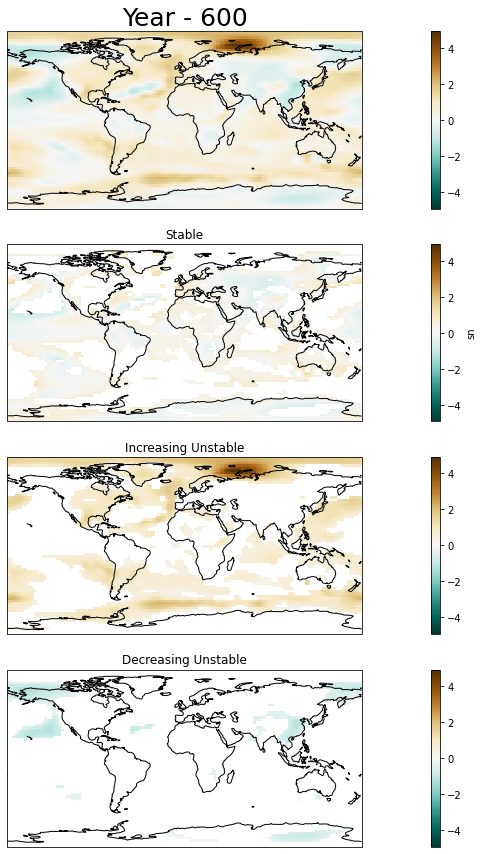

In [72]:
fig = plt.figure(figsize = (25,15))
time_index = 600


ax = fig.add_subplot(411, projection=ccrs.PlateCarree())
plot1 = experiment_sn.isel(time = time_index).plot(ax=ax, cmap='BrBG_r')
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title(f'Year - {time_val.year}', fontsize = 25)


ax = fig.add_subplot(412, projection=ccrs.PlateCarree())
experiment_sn_stable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Stable')


ax = fig.add_subplot(413, projection=ccrs.PlateCarree())
experiment_sn_increasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Increasing Unstable');



ax = fig.add_subplot(414, projection=ccrs.PlateCarree())
experiment_sn_decreasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Decreasing Unstable');

# fig.savefig(f'{IMG_DIR}/{model}_{time_index}_sn.png', bbox_inches='tight', dpi=500)

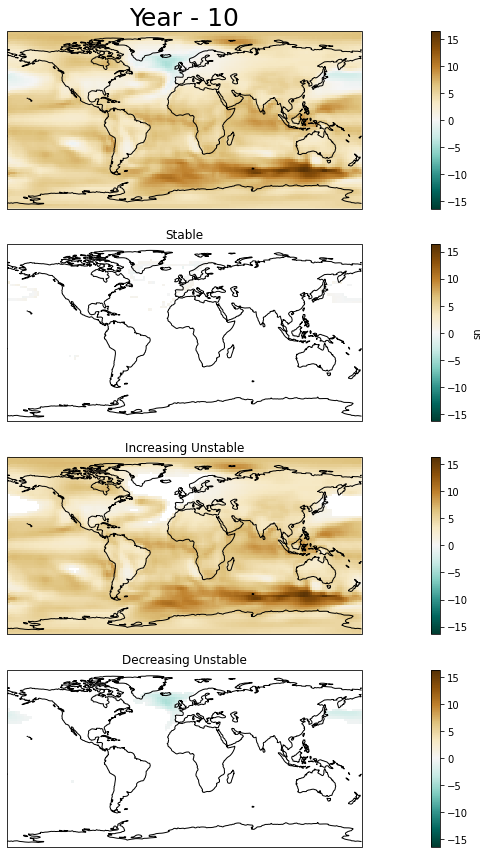

In [73]:
fig = plt.figure(figsize = (25,15))
time_index = 10


ax = fig.add_subplot(411, projection=ccrs.PlateCarree())
plot1 = experiment_sn.isel(time = time_index).plot(ax=ax, cmap='BrBG_r')
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title(f'Year - {time_val.year}', fontsize = 25)


ax = fig.add_subplot(412, projection=ccrs.PlateCarree())
experiment_sn_stable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Stable')


ax = fig.add_subplot(413, projection=ccrs.PlateCarree())
experiment_sn_increasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Increasing Unstable');



ax = fig.add_subplot(414, projection=ccrs.PlateCarree())
experiment_sn_decreasing_unstable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Decreasing Unstable');

# fig.savefig(f'{IMG_DIR}/{model}_{time_index}_sn.png', bbox_inches='tight', dpi=500)

# Consect and First Instance

In [ ]:
# Consectuvie metrics are a bunch of values to unpack what is happening with all the stable points.
# This includes how long till the trend first stabalises, the total number of times the trend stabalises ect.
with ProgressBar():
#     abrupt_sn_stable.sn.calculate_consecutive_metrics()
    stable_ds = abrupt_sn_stable.sn.calculate_consecutive_metrics()

In [ ]:
stable_ds = stable_ds.drop('total_time_stable')

In [ ]:
stable_ds

In [ ]:
stable_ds.first_stable.attrs = {"long_name": "** First Year Stable", 'units':'year'}
stable_ds.average_length.attrs = {"long_name": "** Average Length of Stable Periods", 'units':'year'}
stable_ds.number_periods.attrs = {"long_name": "** Number of Different Stable Periods", 'units':''}
stable_ds.percent_time_stable.attrs = {"long_name": "** Percent of Time Stable", 'units':'%'}

In [ ]:
data_vars = list(stable_ds.data_vars)

figsize = (25, 4 * len(data_vars))
num_plots= len(data_vars)

fig = plt.figure(figsize=figsize)


for pnum, var in enumerate(data_vars):
    ax = fig.add_subplot(int(num_plots/2) + 1, 2, pnum + 1, projection=ccrs.PlateCarree())
    
    stable_ds[var].plot(ax=ax, cmap='Reds', robust=True)
    ax.coastlines()

    ax.set_title(stable_ds[var].long_name, size=15)
    
fig.savefig(f'{IMG_DIR}/{model}_stable_metrics.png', bbox_inches='tight', dpi=500)

#### Lat Lon Exploration

In [ ]:
# Enum class defined above. This continas locations with a lat lon tuple

# Names
# loc_names = np.dstack(np.array([i.name for i in Locations]))

# # Lat and lon for each location
# locs = np.dstack(np.array([i.value for i in Locations]))
# lats, lons = locs[0][0], locs[0][1]

# with ProgressBar():
#     abrupt_sn_sub = abrupt_sn.sel(lat = lats, lon = lons, method='nearest').compute()#scheduler='processes')

In [ ]:
loc = Locations.MELBOURNE

sel_kwarg = dict(lat = loc.value[0], lon = loc.value[1], method='nearest')

In [ ]:
loc.name

In [ ]:
reload(sn_plot)

In [ ]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

sn_plot.temperature_vs_sn_plot(ax,  abrupt_sn.sel(**sel_kwarg), abrupt_anom.sel(**sel_kwarg),
                      temp_highlight = abrupt_anom_stable.sel(**sel_kwarg), 
                      sn_highlight = abrupt_sn_stable.sel(**sel_kwarg))

ax.set_title(loc.name, fontsize = 15);

In [ ]:
loc.name.capitalize()

In [ ]:
for loc in Locations:
    fig = plt.figure(figsize=  (15,10))
    ax = fig.add_subplot(111)


    sel_kwarg = dict(lat = loc.value[0], lon = loc.value[1], method='nearest')
    sn_plot.temperature_vs_sn_plot(ax,  abrupt_sn.sel(**sel_kwarg), abrupt_anom.sel(**sel_kwarg),
                          temp_highlight = abrupt_anom_stable.sel(**sel_kwarg), 
                          sn_highlight = abrupt_sn_stable.sel(**sel_kwarg))

    ax.set_title(f'{loc.name.capitalize()} ({loc.value[0]}$^\circ$, {loc.value[1]}$^\circ$)')
    
    fig.savefig(f'{IMG_DIR}/{model}_{loc.name.capitalize()}_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

# Global Mean

Calculating the s/n for the global mean. Each grid cell is then compared with the global mean.

## Control Bounds

In [ ]:
control_anom

In [ ]:
control_anom_smean = control_anom.clima.space_mean()

In [ ]:
control_anom_smean_signal = control_anom_smean.sn.signal_grad()

In [ ]:
control_anom_smean.sn.signal_grad()
control_anom_smean_loess = control_anom_smean.sn.loess_grid()
control_anom_smean_noise = control_anom_smean_loess.sn.noise_grad()

control_anom_smean_sn = control_anom_smean_signal/control_anom_smean_noise

In [ ]:
control_anom_smean_sn

In [ ]:
control_anom_smean_sn.plot()

In [ ]:
control_smean_ubound = control_anom_smean_sn.reduce(np.nanpercentile, q=90, dim='time')
control_smean_lbound = control_anom_smean_sn.reduce(np.nanpercentile, q=10, dim='time')

In [ ]:
print(control_smean_lbound.values, control_smean_ubound.values)

## Abrupt Values

In [ ]:
abrupt_anom_smean = abrupt_anom.clima.space_mean()
abrupt_anom_smean

In [ ]:
abrupt_anom_smean_signal = abrupt_anom_smean.sn.signal_grad()
abrupt_anom_smean_signal

In [ ]:
abrupt_anom_smean_signal.plot()

plt.title('Signal - QUAD CO2')

In [ ]:
abrupt_anom_smean_loess = abrupt_anom_smean.sn.loess_grid()
abrupt_anom_smean_loess

In [ ]:
abrupt_anom_smean_loess.plot()

In [ ]:
abrupt_anom_smean_noise = abrupt_anom_smean_loess.sn.noise_grad()
abrupt_anom_smean_noise

In [ ]:
abrupt_anom_smean_noise.plot()
plt.title('Noise - QUAD CO2')

In [ ]:
abrupt_anom_smean_sn = abrupt_anom_smean_signal/abrupt_anom_smean_noise
abrupt_anom_smean_sn

In [ ]:
abrupt_anom_smean_sn.plot()
plt.title('S/N - QUAD CO2')

## Global Average Stable Bounds

In [ ]:
abrupt_anom_smean_sn

In [ ]:
# SN
# The global mean signal-to-noise points that are stable
abrupt_anom_smean_sn_stable = abrupt_anom_smean_sn.where(
    np.logical_and(
                        abrupt_anom_smean_sn <= control_smean_ubound,
                        abrupt_anom_smean_sn >= control_smean_lbound 
                            )
                                  )

# TEMP
# The global mean temperature anomalies that are stable
abrupt_anom_smean_stable = abrupt_anom_smean.where(
    np.logical_and(
                        abrupt_anom_smean_sn <= control_smean_ubound,
                        abrupt_anom_smean_sn >= control_smean_lbound 
                            )
                                  )

In [ ]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

sn_plot.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn, abrupt_anom_smean,
                      temp_highlight = abrupt_anom_smean_stable, 
                      sn_highlight = abrupt_anom_smean_sn_stable)


fig.savefig(f'{IMG_DIR}/{model}_global_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

In [ ]:
#The consecutive metrics
stable_smean_ds = abrupt_anom_smean_sn_stable.sn.calculate_consecutive_metrics().compute()

In [ ]:
stable_smean_ds.first_stable.values

In [ ]:
stable_smean_ds

# Grid Vs Global Space Mean

In [ ]:
stable_ds

In [ ]:
stable_ds['stable_year_anom_rel_global'] = stable_ds.first_stable - stable_smean_ds.first_stable.values

In [ ]:

figsize = (25, 8 )
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

stable_ds['stable_year_anom_rel_global'].plot(ax=ax, cmap='BrBG', robust=True, extend='both')
ax.coastlines()

ax.set_title('Stable Year Vs Global Stablisation')

# Animation Trials

In [ ]:
ANIMATION_DIR = '/g/data/w40/ab2313/animation'

In [ ]:
# os.mkdir(os.path.join(ANIMATION_DIR, 'animation'))

os.mkdir(os.path.join(ANIMATION_DIR,'raw_3'))

In [ ]:
RAW_DIR = os.path.join(ANIMATION_DIR,'raw_3')
RAW_DIR

In [ ]:
vmax = abrupt_sn_unstable.reduce(np.nanpercentile, q=99).values
vmin = abrupt_sn_unstable.reduce(np.nanpercentile, q=1).values
print(vmax, vmin)

In [ ]:
time = abrupt_sn.time.values

total = 0
for t in time[::10]:
    fig = plt.figure(figsize = (25,15))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    
    abrupt_sn_unstable.sel(time = t).plot(ax=ax, cmap='copper_r', vmin=vmin, vmax=vmax, extend='both')
    ax.coastlines()
    
    time_val = t.year
    
    ax.annotate(str(time_val), xy=(0.003, 0.95), size = 30, xycoords = 'axes fraction', color='red',
               bbox = {'facecolor':'white'});
    ax.set_title(f'')
    fig.savefig(os.path.join(RAW_DIR, f'{time_val}.png'))
    print(f'{time_val}, ', end='')
    plt.close()

In [ ]:
fig = plt.figure(figsize = (25,15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

abrupt_sn_unstable.sel(time = t).plot(ax=ax, cmap='copper_r', vmin=vmin, vmax=vmax, extend='both')
ax.coastlines()

time_val = t.year

ax.annotate(str(time_val), xy=(0.003, 0.95), size = 30, xycoords = 'axes fraction', color='red',
           bbox = {'facecolor':'white'});
ax.set_title(f'')

In [ ]:
# pyplot needed to plot the dataset, but animation only needed much further down.
from matplotlib import pyplot as plt, animation
%matplotlib inline

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display


In [ ]:
fig = plt.figure(figsize = (25,15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

cax = abrupt_sn_unstable.isel(time = 0).plot(ax=ax, cmap='copper_r', vmin=vmin, vmax=vmax, extend='both')
ax.coastlines()

time_val = t.year

ax.annotate(str(time_val), xy=(0.003, 0.95), size = 30, xycoords = 'axes fraction', color='red',
           bbox = {'facecolor':'white'});
ax.set_title(f'');


# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(abrupt_sn_unstable[frame,:,:].values.flatten())
#     ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=40,       # Could also be iterable or list
    interval=200     # ms between frames
)

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = tas[0,:,:].plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=-40, vmax=40,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(tas[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=40,       # Could also be iterable or list
    interval=200     # ms between frames
)

In [ ]:
# RAW_DIR

# !convert /g/data/w40/ab2313/animation/raw_2/*png /g/data/w40/ab2313/animation/unstable_1.gif

# os.listdir(ANIMATION_DIR)

# !convert